In [1]:
import torch
import numpy as np
import pandas as pd
import src.datasets

from torchvision import datasets
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

In [2]:
import torch 
import numpy as np
import pandas as pd
import skimage 
import src
import src.datasets
import PIL

from src.optimal_transport_modules import icnn_modules as icnn
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.utils import make_grid
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from PIL import Image
from IPython.display import display
from matplotlib import pyplot as plt

In [3]:
%matplotlib inline

# Feature space
In this notebook we explore the feature space we are going to compute the Wasserstein distance on.

In [12]:
def plot_tsne(path, array1, array2, scores, label1 = None, label2 = None):
    
    fig, ax = plt.subplots()
    
    sc1 = plt.scatter(array1[:,0], array1[:,1], marker="^", c="gray", label=label1)
    sc2 = plt.scatter(array2[:,0], array2[:,1], marker="o",
                c=scores, cmap="plasma_r", label = label2)
    plt.title("TSNE representation of the feature space")
    
    plt.legend(handles=[sc1, sc2])
    axcb = fig.colorbar(sc2)
    axcb.set_label('Ranking score')
    
    # plt.savefig(path + "/Tsne_plot.jpeg")
    plt.show()

In [13]:
data = src.datasets.Pet_Features("../data/oxford-iiit-pet/resnet18")

In [14]:
dataloader = torch.utils.data.DataLoader(data, batch_size=1)

In [23]:
results = pd.read_csv("../results/Results_Pet_resnet18/convex_f_40_results.csv", header = None)
results.drop(0, inplace = True)
results.head()

,0,1,2
1,miniature_pinscher_114.pt,32.81824172989161,250.36254117107023
2,leonberger_158.pt,14.632269887203961,232.17656932838258
3,pomeranian_28.pt,10.920192600543828,228.46449204172245
4,beagle_34.pt,20.96769878147586,238.51199822265448
5,american_bulldog_171.pt,6.218095078323472,223.7623945195021


In [24]:
results.columns = ["name", "values", "other_val"]
results.set_index("name", inplace=True)
results = results.astype(float)
results.head()

,values,other_val
name,,
miniature_pinscher_114.pt,32.818242,250.362541
leonberger_158.pt,14.632270,232.176569
pomeranian_28.pt,10.920193,228.464492
beagle_34.pt,20.967699,238.511998
american_bulldog_171.pt,6.218095,223.762395


In [25]:
sample_space = list()
is_cat = list()
values = list()
for batch, cat, name in dataloader:
    sample_space.append(batch.numpy())
    is_cat.append(cat.item())
    if cat == 0:
        values.append(results.loc[name[0], "values"])
    
sample_space = np.concatenate(sample_space)
is_cat = np.array(is_cat)

In [26]:
values = np.array(values)

In [27]:
tsne = TSNE()
transformed_space = tsne.fit_transform(sample_space)

/opt/anaconda3/envs/ot-bias/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/ot-bias/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


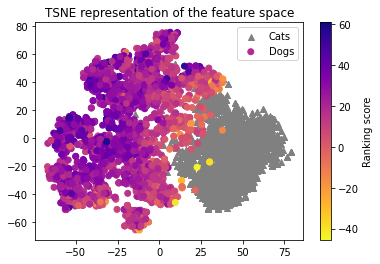

In [28]:
sample1 = np.random.randint(len(transformed_space[is_cat == 1]), size=3000)
sample2 = np.random.randint(len(transformed_space[is_cat == 0]), size=3000)

plot_tsne("",
          transformed_space[is_cat == 1][sample1,:],
          transformed_space[is_cat == 0][sample2,:],
          values[sample2], "Cats", "Dogs")

In [29]:
values.mean()

21.407209822621635

In [51]:
def save_images_as_grid(path, array_img_vectors):

    array_img_vectors = torch.from_numpy(array_img_vectors)\
        .float().permute(0, 3, 1, 2)
    grid = make_grid(array_img_vectors, nrow=6, normalize=True)*255
    ndarr = grid.to('cpu', torch.uint8).numpy().T
    im = Image.fromarray(ndarr.transpose(1, 0, 2))

    #im.save(path)
    display(im)

In [60]:
img_ids = results.sort_values(by="values", ascending=True).index[:36]

for file in img_ids:
    path = "../data/oxford-iiit-pet/images/" + file[:-4] + ".jpg"
    img = Image.open(path)
    img.show()

FileNotFoundError: [Errno 2] No such file or directory: '../data/oxford-iiit-pet/images/shiba_inu_17.jpg'

In [68]:
results["breed"] = results.index.map(lambda x: "_".join(x.split("_")[:-1]))

<AxesSubplot:title={'center':'values'}, xlabel='breed'>

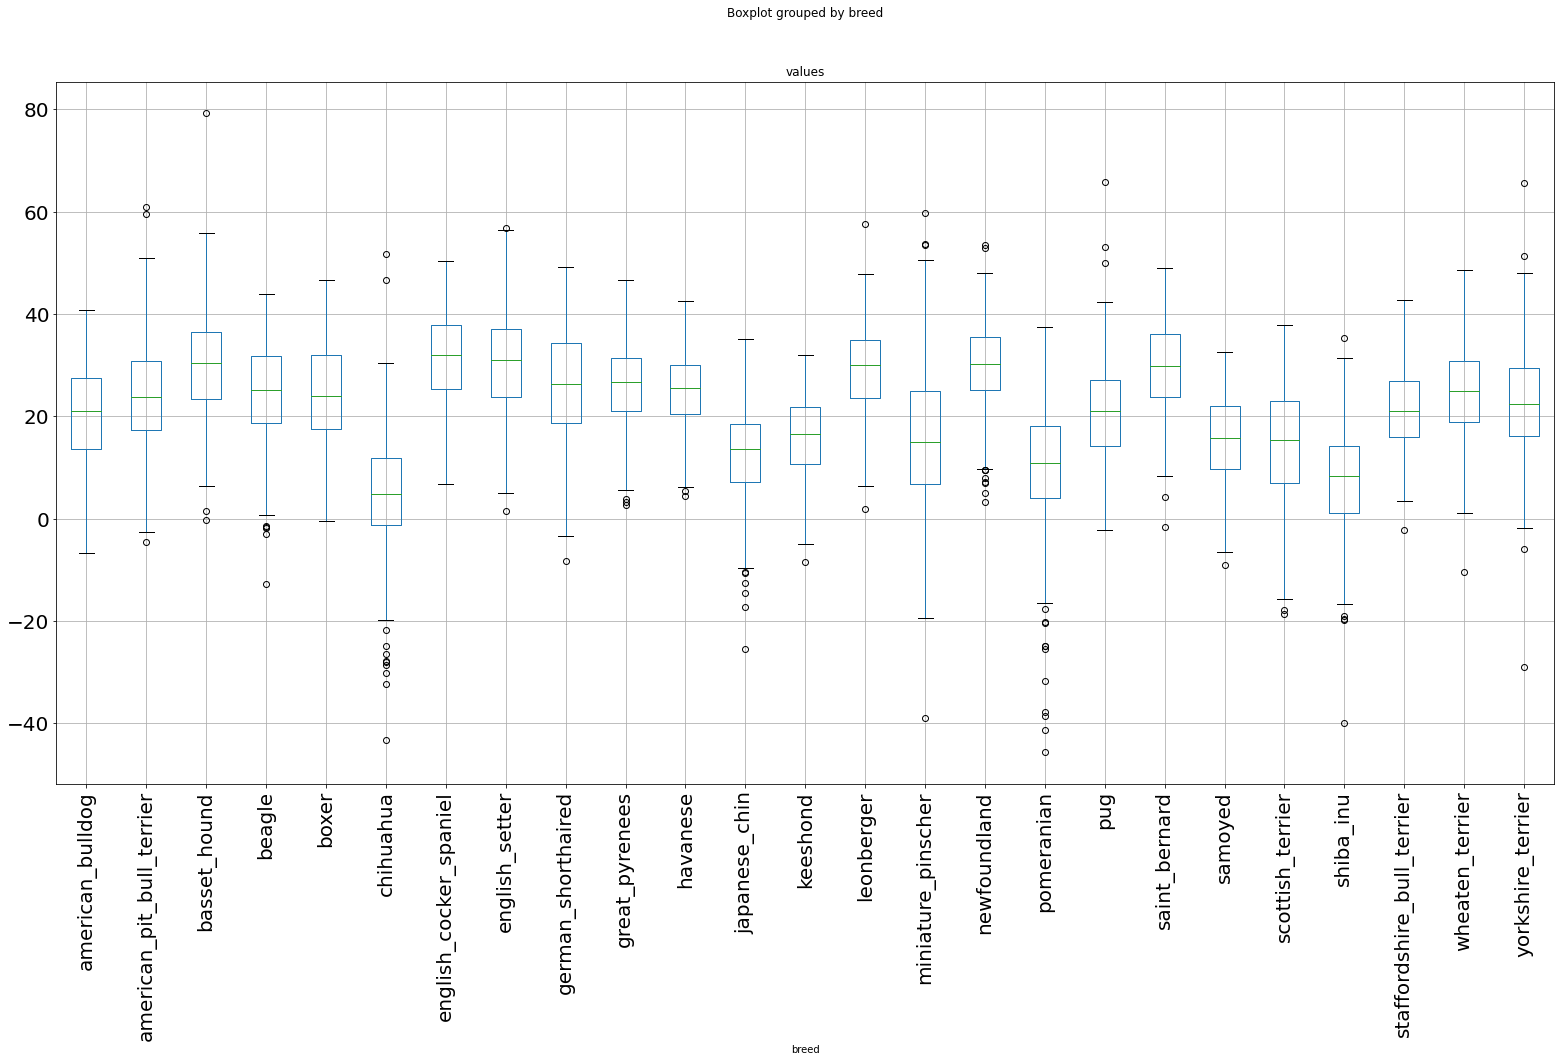

In [77]:
results.boxplot(column = "values", by = "breed", rot = 90, figsize = (26, 13), fontsize = 20 )

In [106]:
def display_sample(breed):
    sample = results[results["breed"] == breed].sample(1).index.values[0]

    file = sample[:-4] + ".jpg"

    path = "../data/oxford-iiit-pet/images/" + file

    img = Image.open(path)
    display(img)

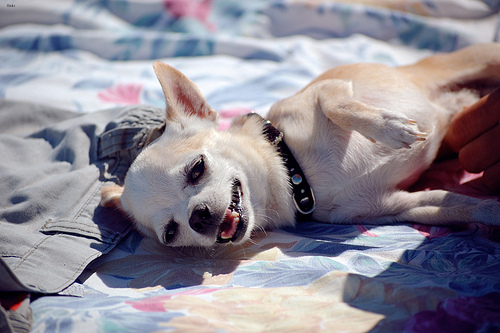

In [107]:
display_sample("chihuahua")

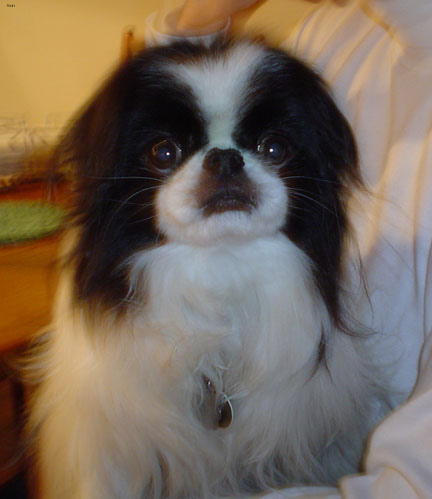

In [108]:
display_sample("japanese_chin")

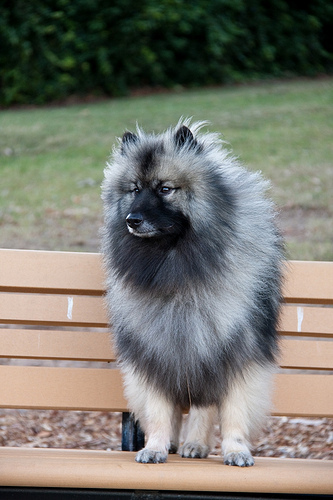

In [109]:
display_sample("keeshond")

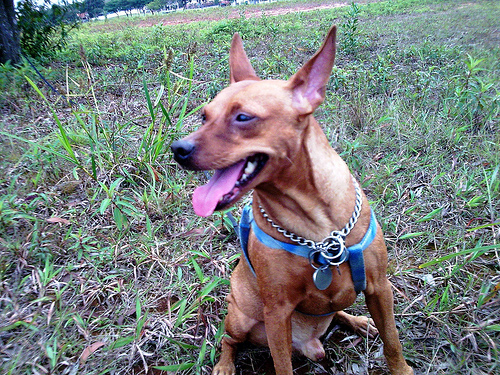

In [110]:
display_sample("miniature_pinscher")

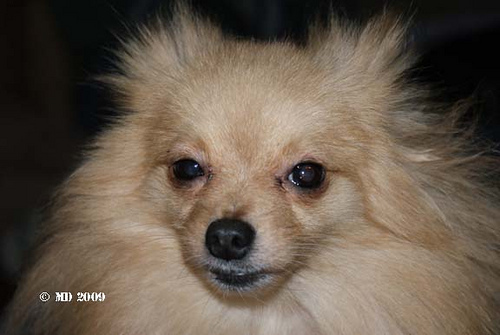

In [111]:
display_sample("pomeranian")

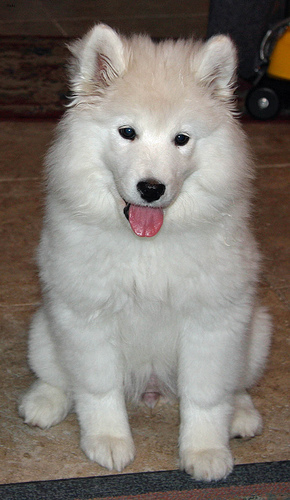

In [115]:
display_sample("samoyed")

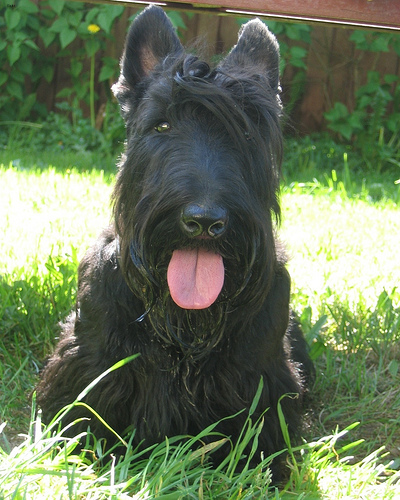

In [119]:
display_sample("scottish_terrier")

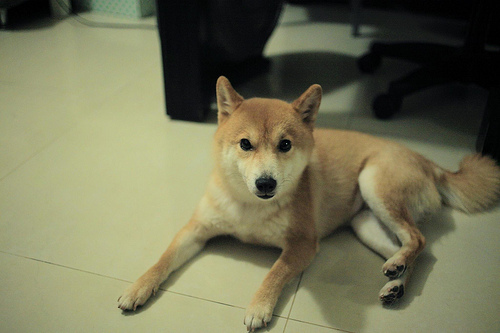

In [123]:
display_sample("shiba_inu")

In [126]:
results["values"].mean()

21.407209822622175